In [1]:
import numpy as np
import pandas as pd
import spiceypy as spice
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import c
from astropy.time import Time
from astroquery.jplhorizons import Horizons
import rebound

In [53]:
def Furnisher(k):
    '''
    This function is used to load all kernels needed in an operation.
    Comment out kernels not in use and add the ones in use.
    
    Arguments: NA
    Returns: NA
    
    '''
    spice.kclear()
    spice.furnsh('/Users/user/Downloads/naif0009.tls.txt')
    if k == '310+341+435':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    elif k == '310+341':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
    elif k == '310+435':
            spice.furnsh('/Users/user/Downloads/de435.bsp')
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
    elif k == '341+435':
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    elif k == '310':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
    elif k == '341':
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
    elif k == '435':
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    pass

In [3]:
def get_spice_function(name,cor,loc):
    """
    This wrapper function automates the creation of objects through the JPL Horizons database. 
    
    Arguments:
    
    name: str
    
    Stipulates the target object in Horizons. The major bodies in the Solar System have an id based on their position.
    Hence '5' refers to Jupiter and '3' to Earth. A single number designator refers to a barycenter and a designator
    such as '599' to the planetary center. For minor bodies in the Solar System, the id_type in the Horizons
    must be changed to "minorbody"
    
    cor: str
    
    Refers to the type of correction that the object has. Available arguments are 'NONE', 'LT','LT+S'
    
    loc: str
    
    Designates the location of observation. Names that start with "g@#" refer to barycenters where the number designates the 
    body that the observer is based at. Hence "g@0" refers to the Solar System barycenter. Also takes Earth location designators.
    Observatories are named after their code. Hence, Pan-Starrs observatory is referred as "f51"

    Returns:
    
    get_target_xyz function
    """    
    def get_target_xyz(t):
        """
        Returns the vectors of the Horizons body at a certain time t.
        
        Arguments:
        
        t: days
        
        Julian date of observation
        
        Returns:
    
        xyz: numpy array
        
        A position vector of the observed object
    
        uvw: numpy array
        
        An instantaneous velocity vector of the observed object
        
        radec: numpy array
        
        The right ascension and declination of the observed object
        """
        
        state,lighttime = spice.spkezr(name,t,'J2000',cor,loc)
        pos,lighttime = spice.spkpos(name,t,'J2000',cor,loc)
        range,ra,dec = spice.recrad(pos) 
        xyz = np.array([state[0],state[1],state[2]])/149597870.7#6.68459e-9
        uvw = np.array([state[3],state[4],state[5]])/149597870.7*24.*3600.#*6.68459e-9
        radec = np.array([ra,dec])
        return xyz,uvw,radec*180/np.pi
    return get_target_xyz

Starting the simulation

In [4]:
def SimStart(bsolar,msolar,iJovian):
    t = 140961664.18440723
    sim = rebound.Simulation()
    k = 0.0172020989484
    sim.G = k**2
    sim.units = ('d', 'AU', 'Msun')
    get_sun = get_spice_function('Sun','NONE','SOLAR SYSTEM BARYCENTER')
    xyz,uvw,radec = get_sun(t) #Adding the Sun
    xyz = xyz
    uvw = (uvw*24*3600)
    sim.add(m=1,x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    for i in range(0,len(bsolar)):
        get_planet = get_spice_function(bsolar[i],'NONE','SOLAR SYSTEM BARYCENTER')
        xyz,uvw,radec = get_planet(t) #Adding Jupiter
        xyz = xyz
        uvw = (uvw*24*3600)
        sim.add(m=msolar[i],x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    ps = sim.particles
    for j in range(1,len(ps)):
        if j not in iJovian:
            print(ps[j].calculate_orbit(primary=ps[0]))
        else:
            print(ps[j].calculate_orbit(primary=ps[bsolar.index('5')+1]))
    return ps,sim

In [97]:
def SimStart2(bsolar,msolar,iJovian):
    t = 140961664.18440723
    sim = rebound.Simulation()
    k = 0.0172020989484
    sim.G = k**2
    #sim.units = ('d', 'AU', 'Msun')
    #sim.G *= (1+delta)
    #get_sun = geta_spice_function('Sun','NONE','SOLAR SYSTEM BARYCENTER')
    #xyz,uvw,radec = get_sun(t) #Adding the Sun
    #xyz = xyz
    #uvw = (uvw*24*3600)
    sim.add(m=1.)#+delta)#,x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    for i in range(0,len(bsolar)):
        get_planet = get_spice_function(bsolar[i],'NONE','SUN')
        xyz,uvw,radec = get_planet(t) #Adding Jupiter
        xyz = xyz
        #uvw = (uvw*24*3600)
        sim.add(m=msolar[i],x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    ps = sim.particles
    for j in range(1,len(ps)):
        if j not in iJovian:
            ps[j].calculate_orbit(primary=ps[0])
        elif bsolar[j-1] == 'Moon':
            ps[j].calculate_orbit(primary=ps[bsolar.index('Earth')+1])
        else:
            ps[j].calculate_orbit(primary=ps[bsolar.index('Jupiter')+1])
    sim.move_to_com()
    jupcom = sim.calculate_com(first=8)
    print(jupcom-sim.particles[3])
    return ps,sim

In [110]:
def Integrator(bsolar,msolar,iJovian,body1,body2):
    ps,sim = SimStart2(bsolar,msolar,iJovian)
    xm = []
    ym = []
    zm = []
    distance = []
    Nout = 100
    year = 365.25 # days
    day = 86400 # s
    tmax = 40*year
    t0 = 140961664.18440723
    times = np.linspace(0, tmax, Nout) # days
    x = np.zeros((len(bsolar)+1,Nout))
    y = np.zeros((len(bsolar)+1,Nout))
    get_ear_an = get_spice_function(body1,'NONE',body2)
    for i, time in enumerate(times):
        tspice = t0 + time*day
        sim.integrate(time)
        for j in range(0,len(bsolar)+1):
            x[j][i] = ps[j].x   # This stores the data which allows us to plot it later
            y[j][i] = ps[j].y
        xyz,uvw,radec = get_ear_an(tspice)
        xm.append(xyz[0])
        ym.append(xyz[1])
        zm.append(xyz[2])
        distance.append(np.sqrt(xm[i]**2 + ym[i]**2 + zm[i]**2))
    return x,y,xm,ym,times,distance

In [86]:
def ErrorSource(bsolar,mass,iJovian,b1,b2):
    x,y,xm,ym,times,distance = Integrator(bsolar,mass,iJovian,b1,b2)
    if b2 == 'Sun':
        temp = 0
    else:
        temp = bsolar.index(b2)+1
    dist1 = x[bsolar.index(b1)+1] - x[temp]
    dist2 = y[bsolar.index(b1)+1] - y[temp]
    return np.array(dist1-xm),np.array(dist2-ym),times,distance

# Match Jupiter from the Sun with just the planets d435

In [82]:
1/328900.559810

3.0404326480249294e-06

In [83]:
mj = 0.0009547919101638659
me = 3.0404326480249294e-06
mv = 2.4478382877865672e-06
mars = 3.2271560375546917e-07
mm = 1.6601141530544803e-07
ms = 0.00028588567270480304
mur = 4.3662496626890934e-05
mnept = 5.1513837726215274e-05
mio = 4.490855574220279e-08
meur = 2.4132928417702382e-08
mga = 7.450560006788226e-08
mcal = 5.409669859576579e-08
man = 0
mpl = 7.350487833457728e-09

In [102]:
Furnisher('435')
xerr,yerr,times,distance = ErrorSource(['1','2','3','4','5','6','7','8','9'],[mm,mv,me,mars,mj,ms,mur,mnept,mpl,mio,meur,mga,mcal,man],[10,11,12,13,14],'5','Sun')



<rebound.Particle object, m=4.851769859925973e-05 x=20.770089032281078 y=-19.021001936899232 z=-8.278822481355249 vx=-0.014672643933426316 vy=0.0023835913095639136 vz=0.0009278432293512262>


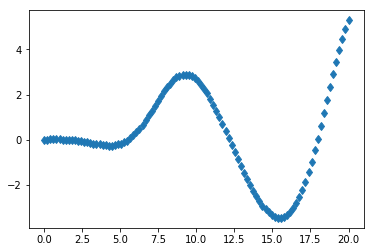

In [103]:
plt.plot(times/365.24,(xerr*1e6)/4,"d")

# Match Jupiter from the Sun with just the planets 310

I am using the masses from the paper and only adding the Sun to see if it includes the inner planets. The error is large

In [42]:
1.266865341960128E+08/1.267127641334463E+08

0.9997929968806782

In [106]:
Furnisher('310+341+435')
mj = 0.0009547919101638659*0.9997929968806782
me = 3.0404326480249294e-06
mv = 2.4478382877865672e-06
mars = 3.2271560375546917e-07
mm = 1.6601141530544803e-07
ms = 0.00028588567270480304
mur = 4.3662496626890934e-05
mnept = 5.1513837726215274e-05
mio = 4.490855574220279e-08
meur = 2.4132928417702382e-08
mga = 7.450560006788226e-08
mcal = 5.409669859576579e-08
man = 0
mpl = 7.350487833457728e-09
xerr,yerr,times,distance = ErrorSource(['1','2','3','4','6','7','8','9','Jupiter','Io','Europa','Ganymede','Callisto','Ananke'],[mm,mv,me,mars,ms,mur,mnept,mpl,mj,mio,meur,mga,mcal,0],[10,11,12,13,14],'Ananke','3')



<rebound.Particle object, m=0.0009517588268827908 x=-5.363977281805212 y=1.5678537868377123 z=0.8076868740583638 vx=-0.018048577318673365 vy=-0.006212658873853664 vz=-0.0026337887390944564>


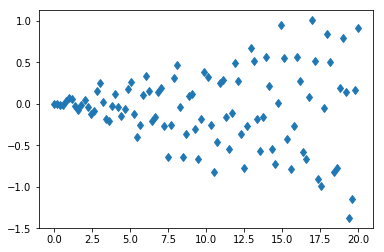

In [107]:
plt.plot(times/365.24,(xerr*1e6)/distance,"d")

* Put in all the barycenters except Jupiter from 435

For jupiter:

- Calculate the barycenter using 310 = xbary
- Get the positions and velocities of Jupiter and the galilean satellites FROM the barycenter of Jupiter = deltax
- Put them into the simulation as x = xbary + deltax

In [189]:
Furnisher('310')
sim = rebound.Simulation()

func = get_spice_function('Jupiter','None','0')
xyz,uvw,radec = func(140961664.18440723)
sim.add(m=mj,x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])

func = get_spice_function('Io','None','0')
xyz,uvw,radec = func(140961664.18440723)
sim.add(m=mio, x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])

func = get_spice_function('Europa','None','0')
xyz,uvw,radec = func(140961664.18440723)
sim.add(m=meur, x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])

func = get_spice_function('Ganymede','None','0')
xyz,uvw,radec = func(140961664.18440723)
sim.add(m=mga, x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])

func = get_spice_function('Callisto','None','0')
xyz,uvw,radec = func(140961664.18440723)
sim.add(m=mcal, x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])

sim.move_to_com()
ps = sim.particles
ps[0]

<rebound.Particle object, m=0.0009545885597112752 x=-4.776779158888189e-07 y=3.609914767110922e-07 z=1.656427700558183e-07 vx=5.8663120155620294e-08 vy=-1.5339260889171008e-07 vz=-6.876251550927068e-08>

In [191]:
func = get_spice_function('Jupiter','None','5')
func(140961664.18440723)

(array([-4.77679195e-07,  3.60990911e-07,  1.65642488e-07]),
 array([ 5.86709634e-08, -1.53407160e-07, -6.87692425e-08]),
 array([142.92099107,  15.4641537 ]))

Now try to find the barycenter of Jupiter within one pixel from 

'''
1. Take 435 with the barycenters, don't include 1,2,3,4 and add their masses
into the Sun. See if the error is within a pixel

-For the masses of Neptune... take the GM of Neptune from 435 and divide it from
the mass of the Sun AND the inner planets from the same file.

Does this work within a pixel?

Sun to Jupiter vector

'''

In [23]:
nmj = 0.0009547862387060006
nms = 0.00028588397455573165
nmur = 4.366223727136226e-05
nmnept = 5.151353173307904e-05
nmpl = 7.3504441714156645e-09
xerr,yerr,times = ErrorSource(['5','6','7','8','9'],[nmj,nms,nmur,nmnept,nmpl],[],'5','Sun')


<rebound.Particle object, m=-4.366223727136226e-05 x=-18.023184673954752 y=7.954918918444482 z=3.7389749577064535 vx=-0.001694691769854902 vy=-0.0030793558102794687 vz=-0.0013247118204276955>


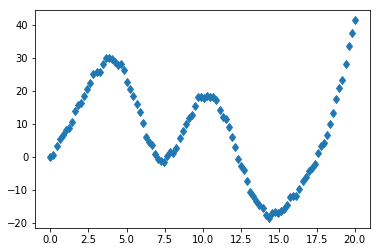

In [24]:
plt.plot(times/365.24,(xerr*1e6)/4,"d")

Okay this didn't work. Now we try to find 5 (Jupiter Barycenter) within one pixel from Earth barycenter.

trying Ananke again with Earth Moon separate

In [93]:
1/27068703.151194

3.6943033229720506e-08

In [111]:
Furnisher('310+341+435')
mj = 0.0009547919101638659*0.9997929968806782
me = 3.0034896147890027e-06
mmoon = 3.6943033229720506e-08
mv = 2.4478382877865672e-06
mars = 3.2271560375546917e-07
mm = 1.6601141530544803e-07
ms = 0.00028588567270480304
mur = 4.3662496626890934e-05
mnept = 5.1513837726215274e-05
mio = 4.490855574220279e-08
meur = 2.4132928417702382e-08
mga = 7.450560006788226e-08
mcal = 5.409669859576579e-08
man = 0
mpl = 7.350487833457728e-09
xerr,yerr,times,distance = ErrorSource(['1','2','Earth','Moon','4','6','7','8','9','Jupiter','Io','Europa','Ganymede','Callisto','Ananke'],[mm,mv,me,mmoon,mars,ms,mur,mnept,mpl,mj,mio,meur,mga,mcal,0],[11,12,13,14,15],'Ananke','Earth')



<rebound.Particle object, m=0.0010033096076422423 x=-4.025982717272712 y=0.5139924446850468 z=0.34255007174961744 vx=-0.017882027637642083 vy=-0.005775174050169907 vz=-0.002452383687202985>


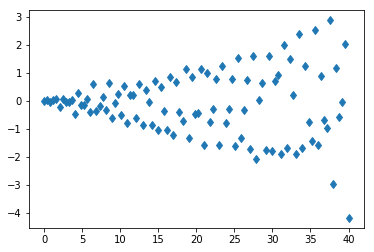

In [112]:
plt.plot(times/365.24,(xerr*1e6)/distance,"d")